In [1]:
import tensorflow as tf

export_dir = "export_sr_70/1721177073"
loaded_model = tf.saved_model.load(export_dir)
predict_fn = loaded_model.signatures['serving_default']


2024-07-20 21:45:55.236290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-20 21:45:55.295351: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2024-07-20 21:45:55.295373: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-07-20 21:45:55.296515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with o

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
import sys 
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

In [4]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR, get_random_kcnfs
from tqdm import tqdm
from collections import Counter

In [5]:
import math
from collections import defaultdict

def jw(clauses):
    score = defaultdict(int)

    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))

    return max(score, key=score.get)


In [6]:
LIMIT_RUNS = 1000

In [7]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [8]:
np.set_printoptions(precision=3, suppress=True)

In [9]:
import tensorflow as tf
import os

BATCH_SIZE = 3

In [10]:
# Because we have to pass full batch

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE, dtype=np.float32)
        
        inputs_tensor = tf.convert_to_tensor(inputs)

        # Hacer la predicción usando la firma
        predictions = predict_fn(input=inputs_tensor)

        # Extraer las probabilidades de política
        policy_probs = predictions['policy_probabilities'].numpy()
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        return best_svar

class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]
    
class JeroslawDPLL(DPLL):
    def suggest(self, cnf: CNF):
        return jw(cnf.clauses)

In [11]:
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)
NormalizedJeroslawDPLL = make_normalized(JeroslawDPLL)

In [12]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [13]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [14]:
# s - number of samples
# n - max number of clauses, use 100 * m
# m - number of variables

def print_all(s, n, m, light=False):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        #sat = get_pos_SR(M, M, N)
        sat = get_random_kcnf(3,N, M)
        sats.append(sat)
    assert len(sats) == S
    
    print("We have generated {} formulas".format(len(sats)))
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    compute_and_print_steps(sats, NormalizedJeroslawDPLL)

We have generated 100 formulas


100%|██████████| 100/100 [00:29<00:00,  3.39it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 9.48; stdev step: 8.25; avg error: 0.83; stdev error: 0.93


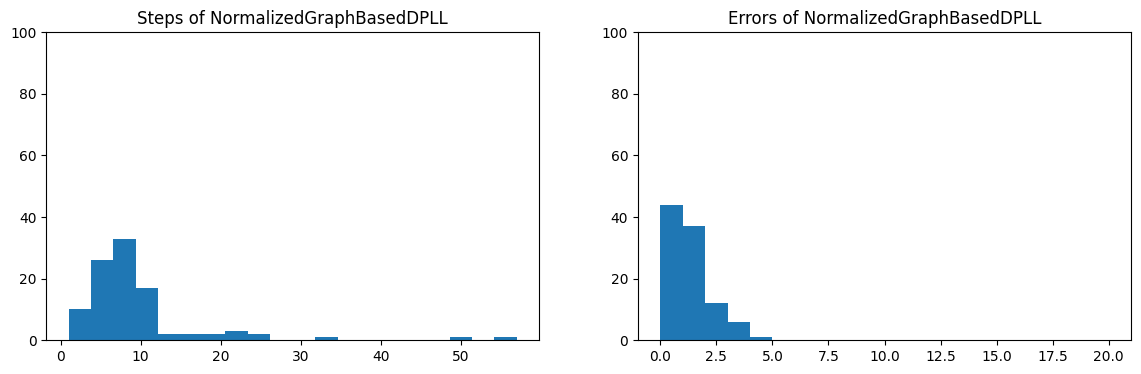

100%|██████████| 100/100 [00:00<00:00, 3327.99it/s]

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 3.62; stdev step: 1.32; avg error: 0.00; stdev error: 0.00


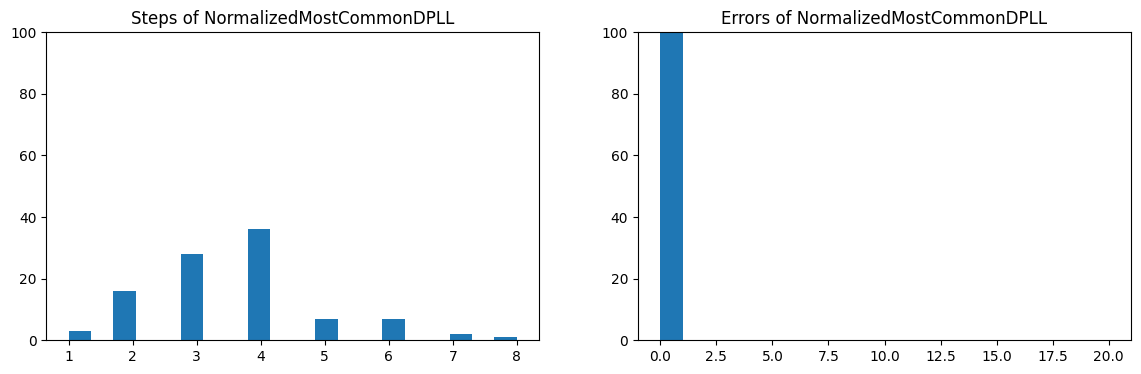

100%|██████████| 100/100 [00:00<00:00, 3247.24it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 3.71; stdev step: 1.42; avg error: 0.00; stdev error: 0.00


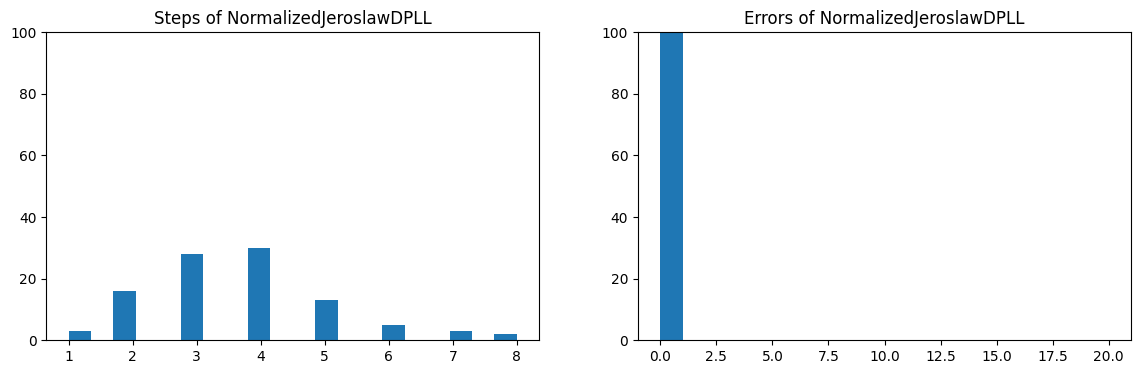

In [15]:
print_all(100, 20, 40)

We have generated 100 formulas


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 13.73; stdev step: 14.85; avg error: 0.85; stdev error: 1.09


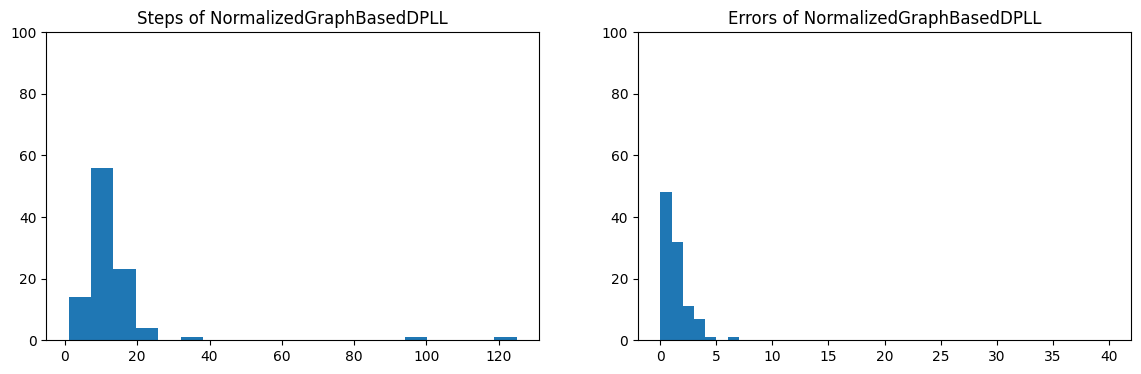

100%|██████████| 100/100 [00:00<00:00, 888.16it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.20; stdev step: 1.68; avg error: 0.00; stdev error: 0.00


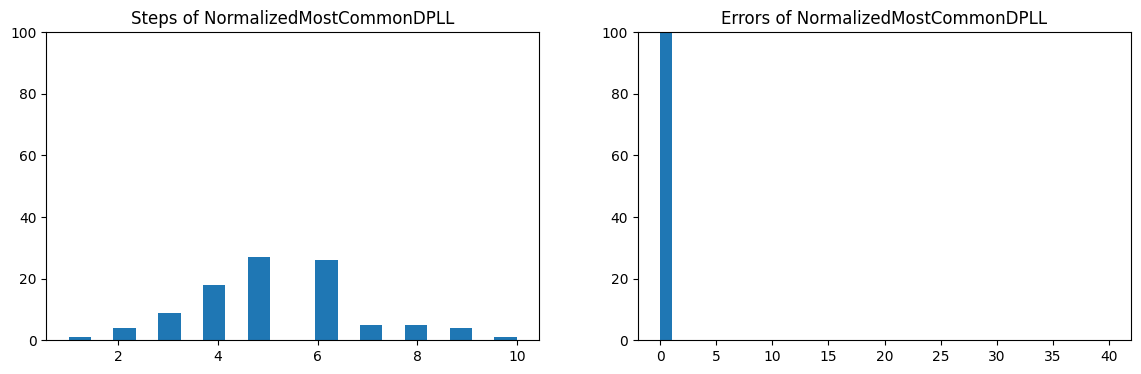

100%|██████████| 100/100 [00:00<00:00, 888.68it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.63; stdev step: 1.95; avg error: 0.00; stdev error: 0.00


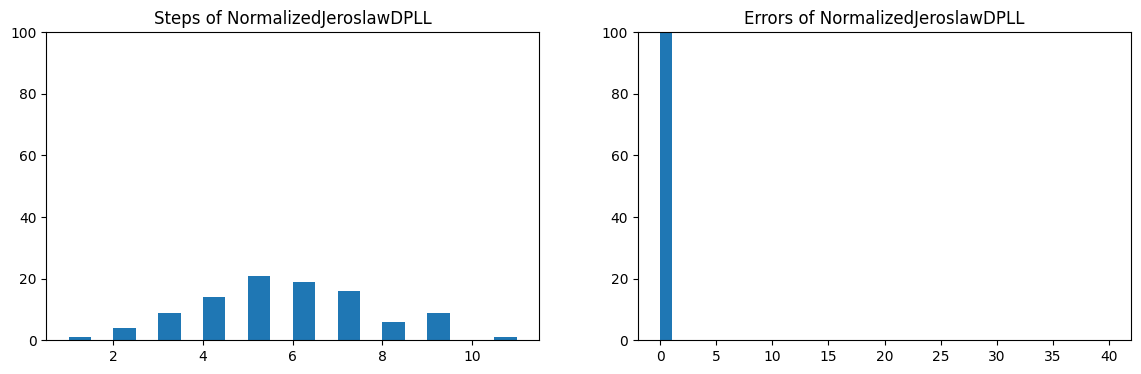

In [16]:
print_all(100, 40, 80)

We have generated 100 formulas


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]

Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.59; stdev step: 19.10; avg error: 1.22; stdev error: 1.40


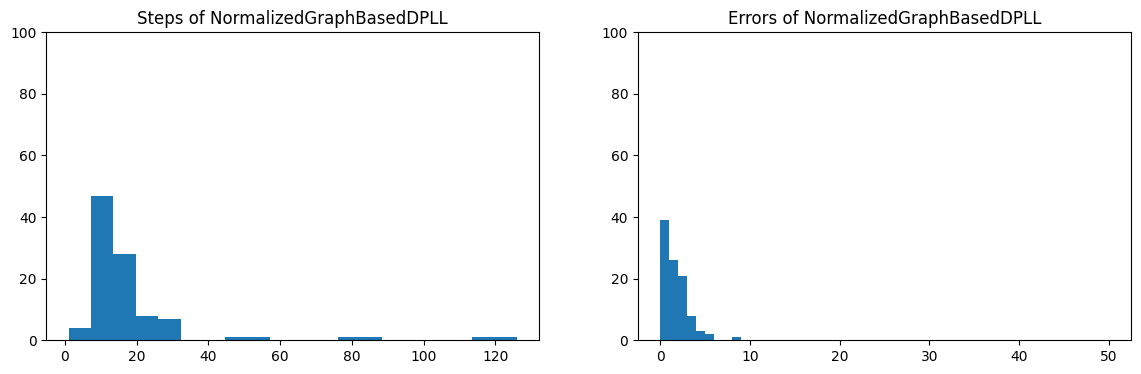

100%|██████████| 100/100 [00:00<00:00, 588.10it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.96; stdev step: 1.82; avg error: 0.00; stdev error: 0.00


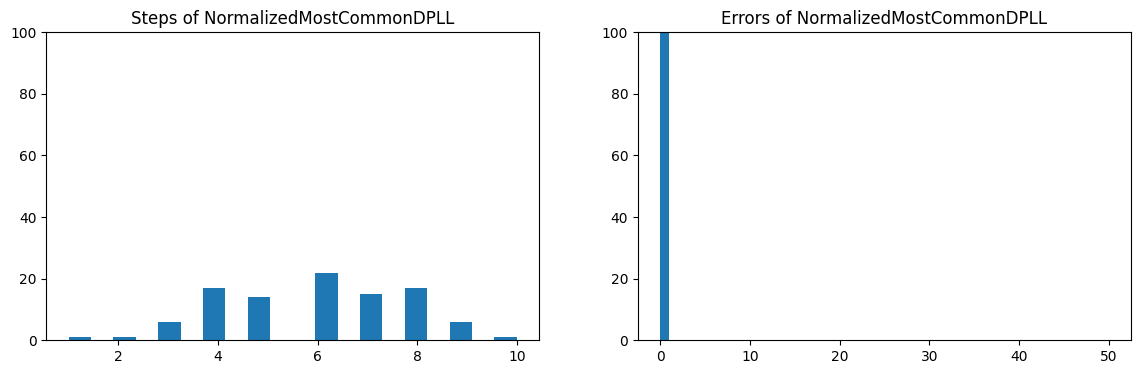

100%|██████████| 100/100 [00:00<00:00, 583.85it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 6.16; stdev step: 1.99; avg error: 0.00; stdev error: 0.00


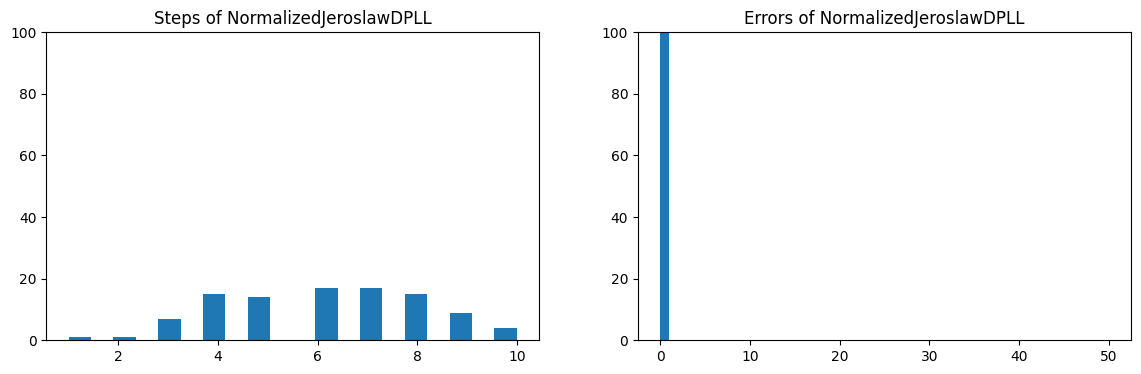

In [17]:
print_all(100, 50, 100)

We have generated 100 formulas


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 23.51; stdev step: 23.49; avg error: 1.10; stdev error: 1.33


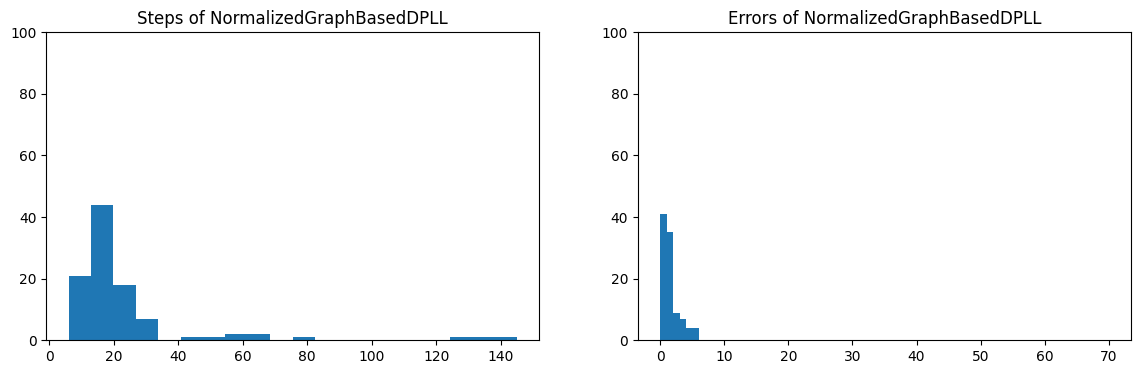

100%|██████████| 100/100 [00:00<00:00, 306.39it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 6.57; stdev step: 2.30; avg error: 0.00; stdev error: 0.00


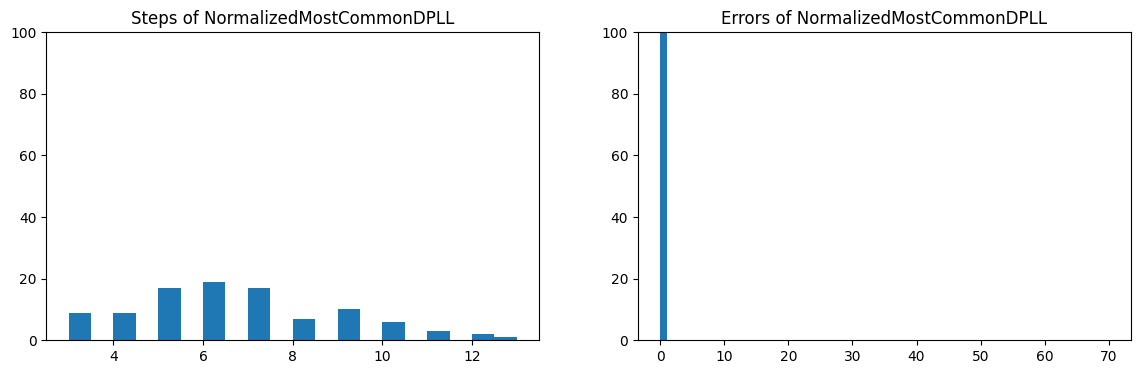

100%|██████████| 100/100 [00:00<00:00, 307.74it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 6.80; stdev step: 2.37; avg error: 0.00; stdev error: 0.00


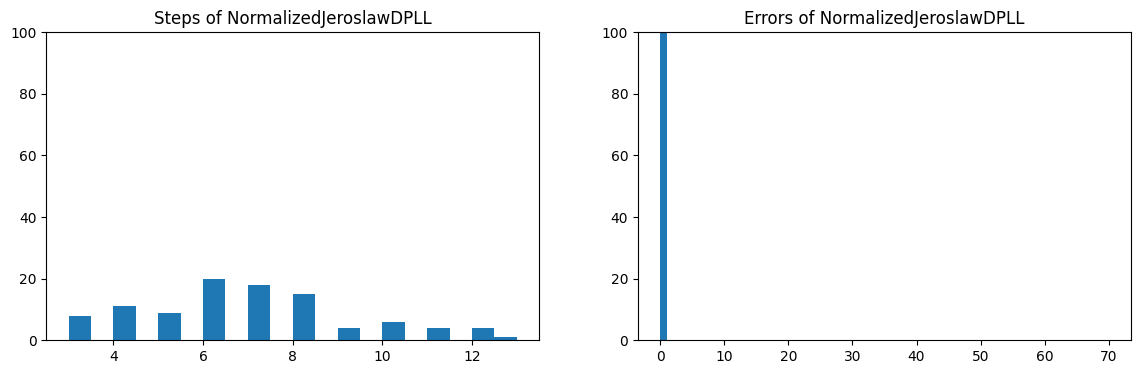

In [18]:
print_all(100, 70, 140)

We have generated 100 formulas


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


Within 1000 steps solved 99 problems out of 100
#Sats: 99; avg step: 27.55; stdev step: 34.00; avg error: 1.02; stdev error: 1.18


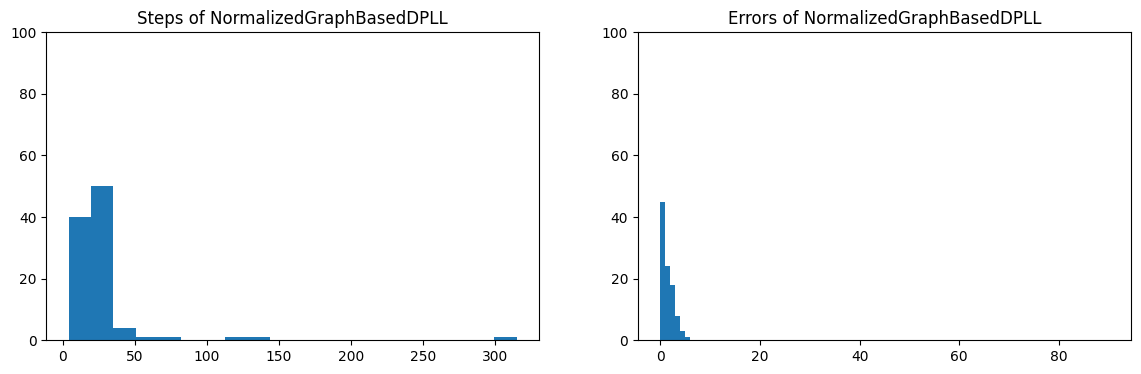

100%|██████████| 100/100 [00:00<00:00, 189.24it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.01; stdev step: 2.85; avg error: 0.00; stdev error: 0.00


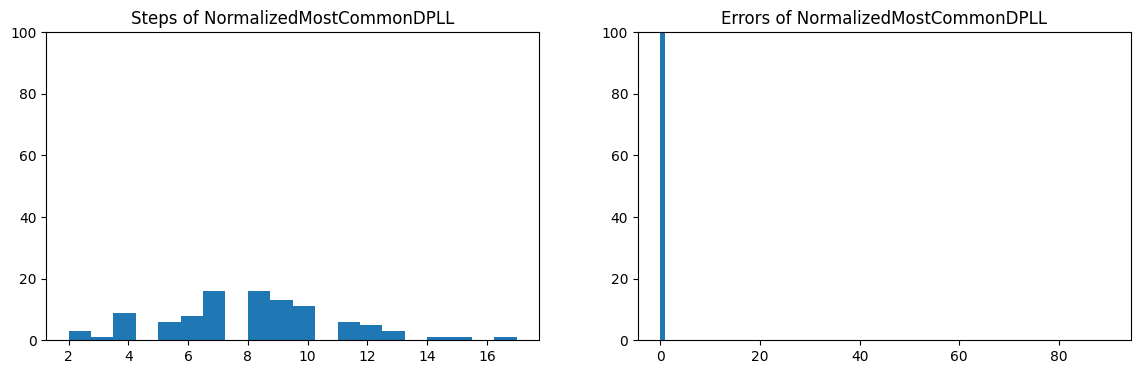

100%|██████████| 100/100 [00:00<00:00, 186.09it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.76; stdev step: 3.29; avg error: 0.00; stdev error: 0.00


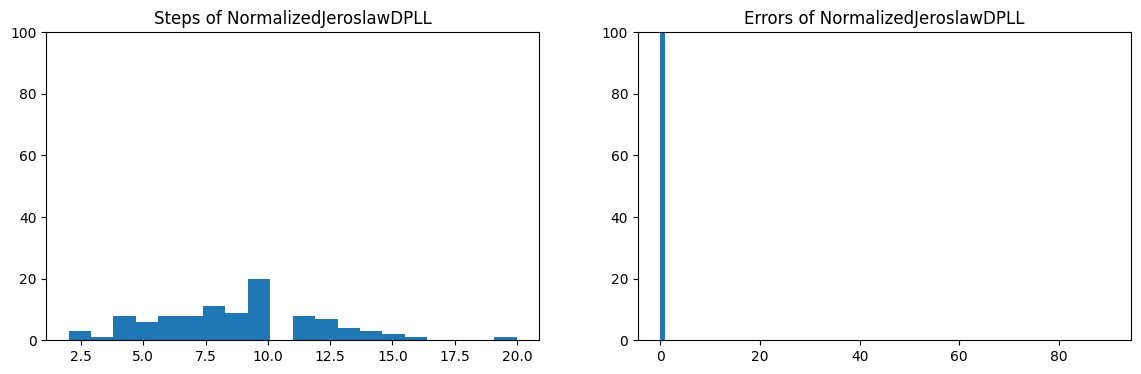

In [19]:
print_all(100, 90, 180)

We have generated 100 formulas


100%|██████████| 100/100 [03:54<00:00,  2.35s/it]


Within 1000 steps solved 99 problems out of 100
#Sats: 99; avg step: 31.54; stdev step: 34.90; avg error: 1.14; stdev error: 1.37


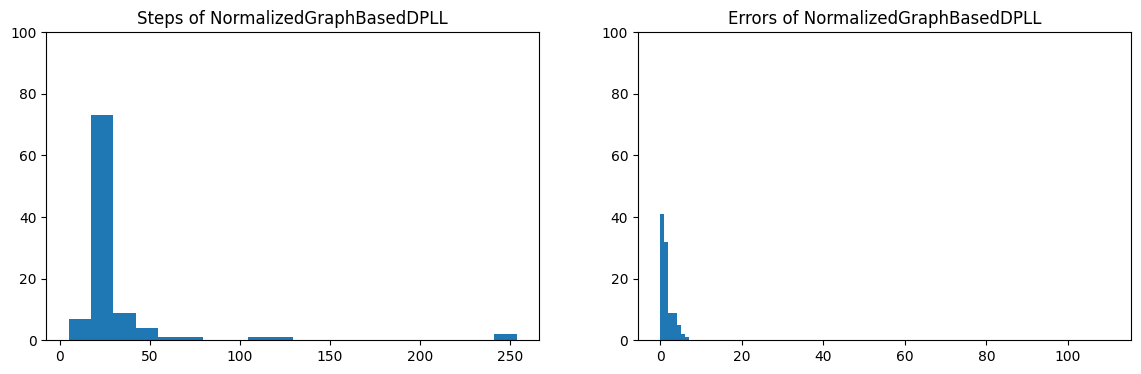

100%|██████████| 100/100 [00:00<00:00, 126.56it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 9.47; stdev step: 2.73; avg error: 0.00; stdev error: 0.00


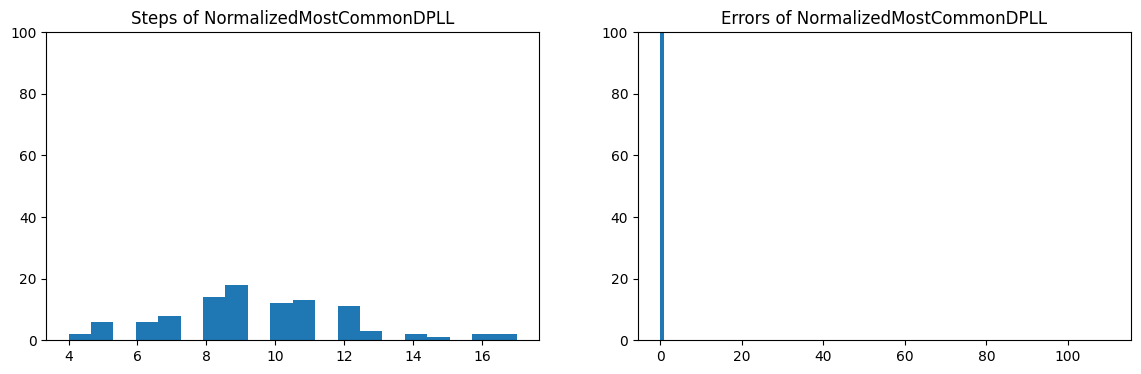

100%|██████████| 100/100 [00:00<00:00, 124.67it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.23; stdev step: 3.00; avg error: 0.00; stdev error: 0.00


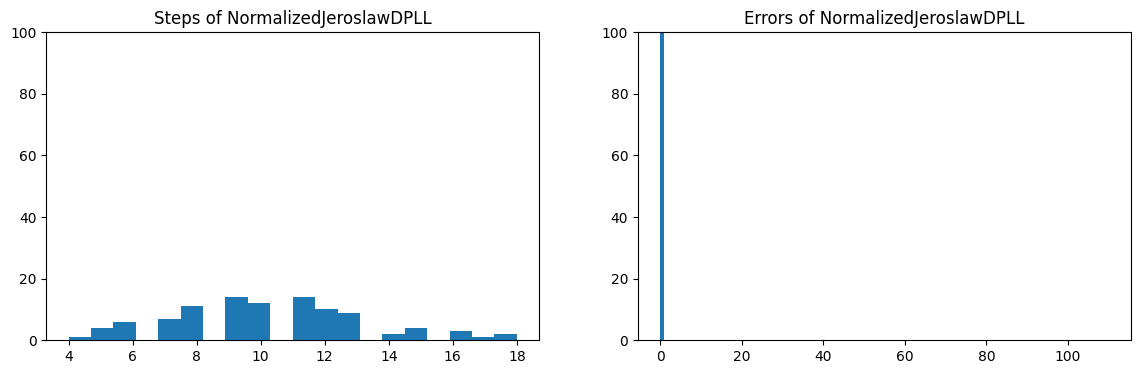

In [20]:
print_all(100, 110, 220)